## Assignment 4: spatial leave-one-out with kNN
The point of this exercise is to investigate the spatial prediction performance of k-nearest neighbor algorithm with the provided data set. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsRegressor

First I read in the data. There are three different datasets:
* coordinates: coordinates of the 1691 labeled datapoints (coordinates)
* input: 95 features (X)
* output: labels (y), water permeability level of soil

In [2]:
df_c=pd.read_csv('COORDINATES.csv', header = None)
print(df_c.head())
print(df_c.shape)
coordinates = df_c.values

          0          1
0  459140.0  7524200.0
1  461590.0  7549000.0
2  462040.0  7549300.0
3  462040.0  7549300.0
4  462130.0  7549400.0
(1691, 2)


In [3]:
df_X=pd.read_csv('INPUT.csv', header= None)
print(df_X.head())
print(df_X.shape)

   0    1    2    3   4   5    6     7    8    9    ...        85      86  \
0   0  464  537  139  53  35  294  1151  236  211   ...    0.2222  0.2222   
1   0  328  404  107  38  36  211   848  392  475   ...    0.2222  0.1111   
2   1  182  219   56  21  36  116   437  108  128   ...    0.0000  0.0000   
3   0  206  268   64  27  24  145   564  253  329   ...    0.0000  0.0000   
4   0   99  114   30  10  26   58   232  265  230   ...    0.0000  0.0000   

       87      88      89      90      91      92      93      94  
0  0.0000  0.0000  0.0000  295.07 -0.0001  2.3657  0.0171  0.0347  
1  0.0000  0.4444  0.0000  257.99 -0.0002  0.7365  0.0088  0.0347  
2  0.0000  0.0000  0.0000  254.19 -0.0003  2.9106  0.0671 -4.1155  
3  0.0000  0.0000  0.0000  253.84  0.0004  3.0498  0.0658 -4.3973  
4  0.3333  0.2222  0.2222  257.65 -0.0001  2.0997  0.0303 -0.9330  

[5 rows x 95 columns]
(1691, 95)


Because I will use K-Nearest Neighbors Regression, which utilizes distances between input data points, I have to normalize the feature matrix. I use z-score to normalize X.

In [4]:
#standardization function
zscore = lambda x: (x - x.mean()) / x.std()
#new standardized dataframe
df_Xs= df_X.copy()
df_Xs = df_Xs.transform(zscore)
df_Xs.describe()

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
count,1.691000e+03,1.691000e+03,1.691000e+03,1.691000e+03,1.691000e+03,1.691000e+03,1.691000e+03,1.691000e+03,1.691000e+03,1.691000e+03,...,1.691000e+03,1.691000e+03,1.691000e+03,1.691000e+03,1.691000e+03,1.691000e+03,1.691000e+03,1.691000e+03,1.691000e+03,1.691000e+03
mean,-6.048122e-16,-1.105890e-15,5.609548e-16,3.710810e-16,-4.228170e-16,-1.426023e-16,-2.300020e-15,-5.449350e-16,-4.222918e-16,2.862550e-16,...,6.829447e-15,1.021202e-14,7.931496e-15,-1.605523e-15,-2.549771e-15,-7.685816e-15,3.863786e-16,-1.976867e-16,1.837810e-15,5.924691e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.725600e-01,-1.110629e+00,-1.133639e+00,-1.080634e+00,-1.181473e+00,-1.130180e+00,-1.219529e+00,-1.134232e+00,-1.481504e+00,-1.216595e+00,...,-1.047414e+00,-8.773768e-01,-6.450629e-01,-5.197639e-01,-4.469571e-01,-1.958934e+00,-1.013569e+01,-2.101941e+00,-1.267605e+00,-2.851510e+00
25%,-2.725600e-01,-6.277071e-01,-6.148404e-01,-6.286841e-01,-6.217260e-01,-6.332841e-01,-6.441661e-01,-6.127482e-01,-6.865239e-01,-6.561353e-01,...,-4.139692e-01,-8.773768e-01,-6.450629e-01,-5.197639e-01,-4.469571e-01,-7.120464e-01,-1.590770e-01,-6.882860e-01,-7.352028e-01,-5.237180e-01
50%,-2.725600e-01,-4.111241e-01,-3.640466e-01,-4.298259e-01,-3.285250e-01,-2.836169e-01,-2.928381e-01,-3.664919e-01,-1.731938e-01,-2.118688e-01,...,-4.139692e-01,-1.692086e-01,-6.450629e-01,-5.197639e-01,-4.469571e-01,-3.736185e-01,8.725925e-02,5.417340e-02,-2.007047e-01,-8.624495e-02
75%,-2.725600e-01,5.225242e-01,5.407780e-01,6.367769e-01,5.377505e-01,3.421034e-01,5.320190e-01,6.535403e-01,6.535856e-01,1.913885e-01,...,2.194760e-01,5.389595e-01,2.692491e-01,2.288536e-01,-4.469571e-01,3.966515e-01,3.335955e-01,5.649406e-01,5.266320e-01,2.826275e-01
max,3.666747e+00,3.531272e+00,3.756839e+00,3.981210e+00,3.376469e+00,6.176024e+00,3.026957e+00,3.794515e+00,4.342294e+00,4.654558e+00,...,4.654162e+00,4.788606e+00,5.755944e+00,3.972615e+00,4.367085e+00,4.251411e+00,5.137152e+00,6.366342e+00,6.978339e+00,1.295089e+01


In [5]:
X = df_Xs.values

In [6]:
df_y=pd.read_csv('OUTPUT.csv', header= None)
print(df_y.head())
print(df_y.shape)
y = df_y.values

        0
0  5.8359
1  6.2592
2  6.9041
3  6.2065
4  7.0642
(1691, 1)


I will use C-index as the accuracy measure (how well the model captures the relative ordering/ranking of the data points).

In [7]:
# function calculates C-index
def cIndex(y_true, y_predicted):
    n=0       # number of true[j] that are not same than true[i]
    h_sum=0   # predicted[i] and predicted[j] are in same order than true[i] and true[j]
    for i in range(len(y_true)):
        t=y_true[i]
        p=y_predicted[i]
        for j in range((i+1), len(y_true)): # following values
            nt=y_true[j]
            np=y_predicted[j] 
            if (t != nt): # following true value is not the same
                n=n+1
                if (t < nt and p < np) or (t > nt and p > np): # same order
                    h_sum = h_sum+1
                elif (p==np):
                    h_sum = h_sum + 0.5
    return h_sum/n 

In the spatial leave-one-out cross validation we prevent the effect of spatial autocorrelation in cross validation performance estimation by removing training data too close to the test data. The notion of ”too close” is quantified by a distance value called the ”dead zone radius”.

I need a function, which returns the set of the indices of the training data points too close to the test point. But before that I use scipy.spatial.distance.pdist to calculate pairwise distances between coordinates.

In [8]:
# pairwise distances between coordinates
d_v = pdist(coordinates, 'euclidean')
#reformats the distance information returned by pdist from a vector into a square matrix. 
D = squareform(d_v)
D

array([[    0.        , 24920.72430729, 25266.97449241, ...,
        64022.74986284, 64426.31139527, 64580.18581577],
       [24920.72430729,     0.        ,   540.83269132, ...,
        53794.14466278, 53906.56824544, 54039.06827472],
       [25266.97449241,   540.83269132,     0.        , ...,
        53311.7482362 , 53420.61025484, 53552.74409402],
       ...,
       [64022.74986284, 53794.14466278, 53311.7482362 , ...,
            0.        ,   800.06249756,   909.3404203 ],
       [64426.31139527, 53906.56824544, 53420.61025484, ...,
          800.06249756,     0.        ,   156.20499352],
       [64580.18581577, 54039.06827472, 53552.74409402, ...,
          909.3404203 ,   156.20499352,     0.        ]])

In [21]:
def detect_dead_zone(D,test_index, radius): # D = distance matrix
    d=D[test_index]                         
    dead_zone_ind = np.argwhere(d <= radius) 
    return set(dead_zone_ind.flatten())     

Now I am ready for spatial leave-one-out cross validation (SLOO) with kNN. I use LeaveOneOut and KNeighborsRegressor from Scikit-learn library.

In [29]:
loo = LeaveOneOut()

def sloo_knn(X, y, k, S, D, radius):
    y_predicted= np.zeros(len(y))
    for train_index, test_index in loo.split(X):
        # based on normal loo
        X_test=X[test_index]
        y_test=y[test_index]
        # detects and removes training data too close to the test data, removes also the test instance
        dead_zone_ind_set = detect_dead_zone(D, test_index, radius)
        X_train=X[list(S-dead_zone_ind_set)]
        y_train=y[list(S-dead_zone_ind_set)]
        #kNN
        knn = KNeighborsRegressor(k)
        knn.fit(X_train,y_train)
        y_predicted[test_index] = knn.predict(X_test)
    C_index= cIndex(y, y_predicted)
    # print('radius =', radius, ', k =',k,': C-index =', C_index) (used only for testing)
    return C_index



I implement sloo_knn for the following dead zone radiuses: radius = 0, 10, ..., 200 (that is, 10 meter intervals).
For each dead zone radius, I try the k-values [1, 3, 5, 7, 9] in kNN in order to find the best value of k for each d.  

In [30]:
l_radius = list(range(0,201,10)) 
l_k = list(range(1,10,2))     
print(l_radius)
print(l_k)
S = set(range(len(D)))

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]
[1, 3, 5, 7, 9]


In [31]:
best_C_indices = [] # the best value of C-index for each dead zone radius
#best_k = []         # the best value of k for each dead zone radius (not needed)

for radius in l_radius:
    c_indices = []  # the values of C-indices for each k with this radius
    for k in l_k:     
        C_index = sloo_knn(X, y, k, S, D, radius) # the value of C-index with this radius and this k
        c_indices.append(C_index)
    best_C_indices.append(np.max(c_indices))
    # best_k.append(2 * np.argmax(c_indices) + 1) (not needed)
    print('radius =', radius, ', best k =', 2 * np.argmax(c_indices) + 1,': C-index =', np.max(c_indices))
    

radius = 0 , best k = 9 : C-index = 0.7216230196450095
radius = 10 , best k = 9 : C-index = 0.7118687607530984
radius = 20 , best k = 9 : C-index = 0.7113976893000284
radius = 30 , best k = 7 : C-index = 0.7054938970698376
radius = 40 , best k = 9 : C-index = 0.7037310538981337
radius = 50 , best k = 9 : C-index = 0.7004013556778459
radius = 60 , best k = 9 : C-index = 0.6986441121668027
radius = 70 , best k = 9 : C-index = 0.6940376913159062
radius = 80 , best k = 9 : C-index = 0.6906201484190058
radius = 90 , best k = 7 : C-index = 0.6891771858625367
radius = 100 , best k = 7 : C-index = 0.687692925808696
radius = 110 , best k = 7 : C-index = 0.6560481934794752
radius = 120 , best k = 7 : C-index = 0.6356706783568916
radius = 130 , best k = 7 : C-index = 0.6227470115311012
radius = 140 , best k = 7 : C-index = 0.620645038910642
radius = 150 , best k = 7 : C-index = 0.618361777276297
radius = 160 , best k = 7 : C-index = 0.619393514753006
radius = 170 , best k = 7 : C-index = 0.618633

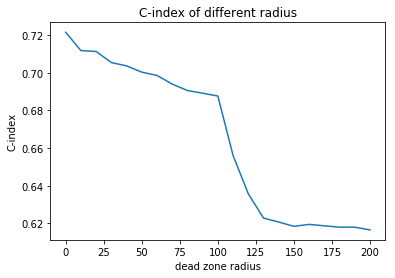

In [33]:
plt.plot(l_radius, best_C_indices )
plt.title('C-index of different radius')
plt.ylabel('C-index')
plt.xlabel('dead zone radius')
plt.show()